In [3]:
using Interact, StatsPlots, DataFrames, CSV, Dates;
# WebIO.install_jupyter_nbextension() # need to restart Jupyter afterwards in order to work

In [4]:
date="200421";
h_predict=24;
h_control=6;
n_peers=5;
h_start=1;
h_end=8760;

In [5]:
Input_df = CSV.read("data/200124_datafile_all_details_right_timestamp.csv");

In [6]:
Flow_df = CSV.read("results/$(date)_results_$(h_predict)_$(h_control)_$(n_peers)_$(h_start)-$(h_end).csv");

In [7]:
first(Flow_df, 3)

,Temp_FH,Vol_HW,Soc_B,SoC_HW_plus,SoC_HW_minus,SoC_FH_plus,SoC_FH_minus
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,22.0,180.0,13.5,0.0,0.0,0.0,0.0
2,22.0,179.329,10.1987,0.0,0.0,0.0,0.0
3,22.0,178.658,6.89763,0.0,0.0,0.0,0.0


In [8]:
first(Input_df, 3)

,heating,heating_fan,hotwater,lights,lgappl,vent_fan,misc,electkwh
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,3.73669,0.044709,0.0,0.022749,0.042381,0.0,0.176259,0.241389
2,3.83768,0.035999,0.0,0.013649,0.041584,0.0,0.166187,0.22142
3,6.05949,0.041142,0.0,0.009099,0.036289,0.0,0.161151,0.206539


In [9]:
# merge on data stamp
Data_df = join(Flow_df, Input_df, on=[:month, :day, :hour], kind=:left);
first(Data_df,3)

,Temp_FH,Vol_HW,Soc_B,SoC_HW_plus,SoC_HW_minus,SoC_FH_plus,SoC_FH_minus
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,22.0,180.0,13.5,0.0,0.0,0.0,0.0
2,22.0,179.329,10.1987,0.0,0.0,0.0,0.0
3,22.0,178.658,6.89763,0.0,0.0,0.0,0.0


In [10]:
size(Data_df)

(43680, 42)

In [186]:
println.(names(Data_df));

Temp_FH
Vol_HW
Soc_B
SoC_HW_plus
SoC_HW_minus
SoC_FH_plus
SoC_FH_minus
profits
COP_FH
COP_HW
Peer
PV_DE
B_DE
GR_DE
PV_B
PV_GR
PV_HP
GR_HP
B_HP
HP_FH
HP_HW
PV_PM
B_PM
PM_DE
PM_B
PM_HP
month
day
hour
horizon
heating
heating_fan
hotwater
lights
lgappl
vent_fan
misc
electkwh
heatingkwh
hotwaterkwh
PV_generation
Temperature


In [167]:
function bar_PV(Data_df, day, month, peer)
    # bars
    @df Data_df[(Data_df[:,:day].==day) .&(Data_df[:,:month].==month) .&(Data_df[:,:Peer].==peer),:] groupedbar(
        [:PV_PM :PV_HP :PV_GR :PV_B :PV_DE], color =[:green :firebrick :grey :purple :orange], 
        ylim=(0,15), yticks=0:5:15, xticks=0:6:24,
        annotations=(2,12, text("$(month)/$(day)", 10)), legendfontsize=6, 
        label=["PV_HP" "PV_GR" "PV_B" "PV_DE"], legend=false, bar_position = :stack, alpha=0.8);
    # battery cap
    @df Data_df[(Data_df[:,:day].==day) .&(Data_df[:,:month].==month) .&(Data_df[:,:Peer].==peer),:] plot!(
        [:Soc_B], color =[:purple], ylim=(0,15), yticks=0:2:15, xticks=0:6:24, 
        label=["SOC_b"], legend=false, linewidth= 2.0);
    # PV generation
    @df Data_df[(Data_df[:,:day].==day) .&(Data_df[:,:month].==month) .&(Data_df[:,:Peer].==peer),:] plot!(
        [:PV_generation], ylim=(0,15), yticks=0:5:15, xticks=0:6:24, color =[:gold], 
        label=["g_e"], legend=false, linewidth= 2.0);
    
    plot!(0:23, ones(24,1)*13.5, linestyle=:dot, linewidth= 2, color=:purple)
end

bar_PV (generic function with 1 method)

In [227]:
function bar_row(plotfunction, Data_df, day, month, peer, length)
    plot([plotfunction(Data_df, (day+i-1), month, peer) for i in 1:length]..., layout=(1,length), size=(300*length,200));
end

bar_row (generic function with 2 methods)

In [14]:
month=1;
day=4;
length=4;
peer=1;

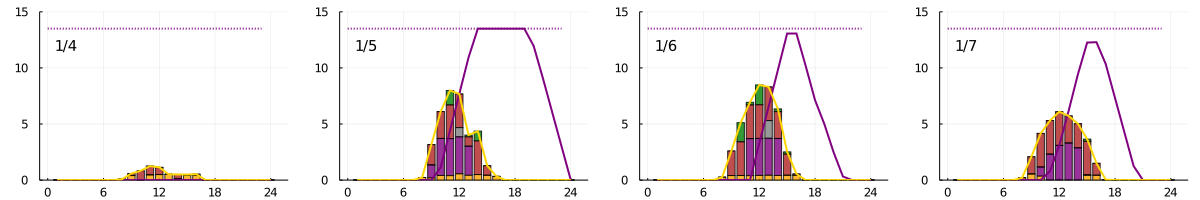

In [168]:
bar_row(bar_PV, Data_df, day, month, peer, length)

In [139]:
function bar_demand(Data_df, day, month, peer)
    # bars
    @df Data_df[(Data_df[:,:day].==day) .&(Data_df[:,:month].==month) .&(Data_df[:,:Peer].==peer),:] groupedbar(
        [:PM_DE :B_DE :GR_DE :PV_DE ], color =[:green :purple :grey :gold], 
        ylim=(0,2), yticks=0:0.5:2, xticks=0:6:24,
        annotations=(2,1.8, text("$(month)/$(day)", 10)), legendfontsize=6, 
        label=["PM_DE" "B_DE" "GR_DE" "PV_DE"], legend=false, bar_position = :stack, alpha=0.8);
    # electricity demand
    @df Data_df[(Data_df[:,:day].==day) .&(Data_df[:,:month].==month) .&(Data_df[:,:Peer].==peer),:] plot!(
        [:electkwh], ylim=(0,2), yticks=0:0.5:2, xticks=0:6:24, color =[:orange], 
        label=["d_e"], legend=false, linewidth= 2.0);
    
    plot!(0:23, ones(24,1)*13.5, linestyle=:dash, color=:purple)
end

bar_demand (generic function with 1 method)

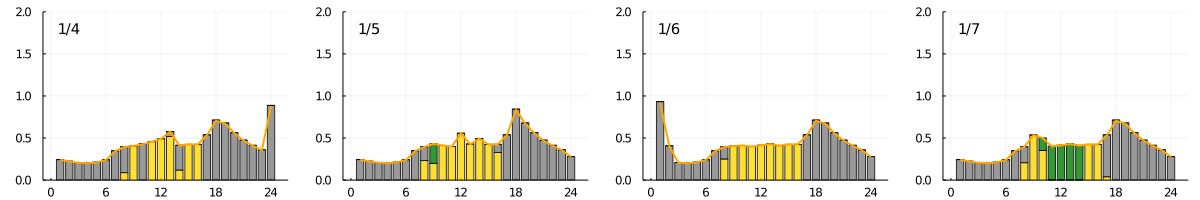

In [140]:
bar_row(bar_demand, Data_df, day, month, peer, length)

In [165]:
function bar_heat(Data_df, day, month, peer)
    # hot water demand
    @df Data_df[(Data_df[:,:day].==day) .&(Data_df[:,:month].==month) .&(Data_df[:,:Peer].==peer),:] plot(
        [:hotwaterkwh]+[:heatingkwh], fillrange=[:heatingkwh], ylim=(0,15), yticks=0:5:15, xticks=0:6:24, 
        color =[:steelblue], label=["d_fh"], legend=false, alpha=0.2);
    # heat demand
    @df Data_df[(Data_df[:,:day].==day) .&(Data_df[:,:month].==month) .&(Data_df[:,:Peer].==peer),:] plot!(
        [:heatingkwh], fillrange=zeros(24), ylim=(0,15), yticks=0:5:15, xticks=0:6:24, 
        color =[:firebrick], label=["d_fh"], legend=false, alpha=0.2);
    # bars
    @df Data_df[(Data_df[:,:day].==day) .&(Data_df[:,:month].==month) .&(Data_df[:,:Peer].==peer),:] groupedbar!(
        [:PM_HP :B_HP :GR_HP :PV_HP], color =[:green :purple :grey :gold], 
        ylim=(0,15), yticks=0:5:15, xticks=0:6:24,
        annotations=(2, 14, text("$(month)/$(day)", 10)), legendfontsize=6, 
        label=["PM_DE" "B_DE" "GR_DE" "PV_DE"], legend=false, bar_position = :stack, alpha=0.8);
    
    plot!(0:23, ones(24,1)*3, linestyle=:dot, linewidth= 2, color=:grey)
end

bar_heat (generic function with 1 method)

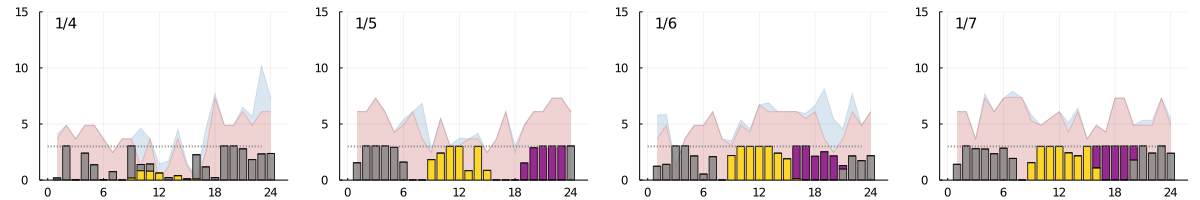

In [166]:
bar_row(bar_heat, Data_df, day, month, peer, length)

In [215]:
function bar_comfort(Data_df, day, month, peer)
    @df Data_df[(Data_df[:,:day].==day) .&(Data_df[:,:month].==month) .&(Data_df[:,:Peer].==peer),:] groupedbar(
        ([:HP_FH :HP_HW].>0)*200, color =[:firebrick :steelblue], 
        ylim=(19,23), yticks=20:1:22, xticks=0:6:24,
        annotations=(2, 22.5, text("$(month)/$(day)", 10)), legendfontsize=6, 
        label=["Mod_fh" "Mod_hw"], legend=false, bar_position = :stack, alpha=0.15);
    
    # state-of-charge fh
    @df Data_df[(Data_df[:,:day].==day) .&(Data_df[:,:month].==month) .&(Data_df[:,:Peer].==peer),:] plot!(
        [:Temp_FH], ylim=(19,23), yticks=20:1:22, xticks=0:6:24, color =[:firebrick], 
        label=["T_fh"], legend=false, linewidth= 2.0);
    
    plot!(0:23, ones(24,1)*20, linestyle=:dot, linewidth= 2, color=:firebrick)
    plot!(0:23, ones(24,1)*22, linestyle=:dot, linewidth= 2, color=:firebrick)
    
    plt = twinx()
    # state-of-charge hw
    @df Data_df[(Data_df[:,:day].==day) .&(Data_df[:,:month].==month) .&(Data_df[:,:Peer].==peer),:] plot!(
        plt, [:Vol_HW], ylim=(10,190), yticks=20:40:180, xticks=0:6:24, color =[:steelblue], 
        label=["V_fh"], legend=false, linewidth= 2.0, linestyle=:dash, grid=false);
    
    plot!(plt, 0:23, ones(24,1)*20, linestyle=:dot, linewidth= 2, color=:steelblue)
    plot!(plt, 0:23, ones(24,1)*180, linestyle=:dot, linewidth= 2, color=:steelblue)
end

bar_comfort (generic function with 1 method)

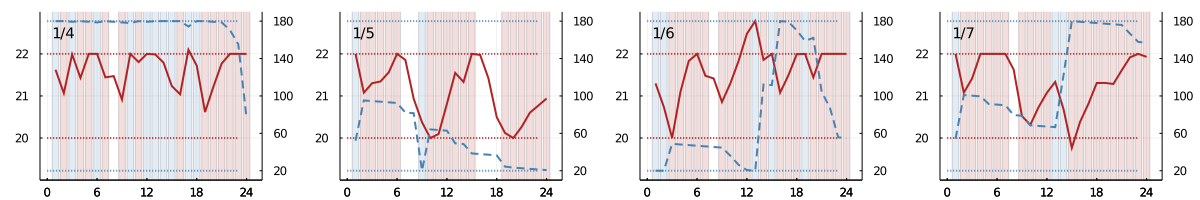

In [216]:
bar_row(bar_comfort, Data_df, day, month, peer, length)

In [284]:
@manipulate for Start=Date(2015,1,1), 
    Days=1:1:10, 
    Peer=string.(collect(1:n_peers))
    
    p1=bar_row(bar_PV, Data_df, Dates.day(Start), Dates.month(Start), parse(Int, Peer), Days);
    p2=bar_row(bar_demand, Data_df, Dates.day(Start), Dates.month(Start), parse(Int, Peer), Days);
    p3=bar_row(bar_heat, Data_df, Dates.day(Start), Dates.month(Start), parse(Int, Peer), Days);
    p4=bar_row(bar_comfort, Data_df, Dates.day(Start), Dates.month(Start), parse(Int, Peer), Days);
    
    vbox(vskip(1em),
        md"*Interactive illustration of peer SHEMS results:*",
        vskip(1em),
        plot(p1,p2,p3,p4, layout=(4,1), size=(Days*300,4*200)))
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["Start"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:attributes => Dict{Any,Any}(:type => "date",Symbol("data-bind") => "value: value, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}"),:className => "input ",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[], Dict{Symbol,Any}())], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"value" => (Observable{Any} with 2 listeners. Value:
"2015-01-01", nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "C:\\Users\\Lissy\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\Lissy\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\Lissy\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\Lissy\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\Lissy\\.julia\\packages\\Interact\\SbgIk\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"value" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"value\"]()) ? (this.valueFromJulia[\"value\"]=true, this.model[\"value\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000014ec76b0, Task (runnable) @0x0000000014ec76b0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"15551525262595916591\",\"id\":\"ob_262\",\"type\":\"observable\"}),\"value\":WebIO.getval({\"name\":\"value\",\"scope\":\"15551525262595916591\",\"id\":\"ob_261\",\"type\":\"observable\"})};\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_dat